<a href="https://colab.research.google.com/github/laipching/laipching/blob/main/Desempe%C3%B1o%20de%20equipos%20cr%C3%ADticos%20en%20producci%C3%B3n%20farmac%C3%A9utica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis del desempeño de equipos críticos en producción farmacéutica

Lai Yi Peña Ching

Este análisis evalúa desviaciones, OOS y tiempos de inactividad de equipos críticos en la fabricación de productos estériles.  
El objetivo es identificar equipos con mayor impacto en calidad y eficiencia para apoyar decisiones de CQV, QA y Producción.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
# Dataset FARMA
rng = np.random.default_rng(42)
n_pharma = 500

pharma = pd.DataFrame({
    "batch_id": np.arange(1, n_pharma+1),
    "producto": rng.choice(["Producto A", "Producto B", "Producto C"], n_pharma),
    "linea_produccion": rng.choice(["L1", "L2", "L3"], n_pharma),
    "equipo_id": rng.choice(["EQ-01", "EQ-02", "EQ-03", "EQ-04", "EQ-05"], n_pharma),
    "fecha": pd.date_range("2024-01-01", periods=n_pharma, freq="D"),
    "desviacion": rng.choice([0, 1], n_pharma, p=[0.8, 0.2]),
    "tipo_desviacion": rng.choice(["Ninguna", "OOS", "OOT", "Desviación GMP"], n_pharma),
    "downtime_min": rng.integers(0, 240, n_pharma),
    "estado_lote": rng.choice(["Aprobado", "Rechazado", "Retrabajo"], n_pharma, p=[0.8, 0.1, 0.1])
})
pharma.head()

,batch_id,producto,linea_produccion,equipo_id,fecha,desviacion,tipo_desviacion,downtime_min,estado_lote
0,1,Producto A,L1,EQ-05,2024-01-01,0,OOT,186,Aprobado
1,2,Producto C,L2,EQ-04,2024-01-02,0,Ninguna,161,Aprobado
2,3,Producto B,L3,EQ-03,2024-01-03,0,Desviación GMP,223,Rechazado
3,4,Producto B,L3,EQ-05,2024-01-04,0,Ninguna,230,Rechazado
4,5,Producto B,L1,EQ-01,2024-01-05,0,Ninguna,169,Aprobado


In [3]:
pharma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   batch_id          500 non-null    int64         
 1   producto          500 non-null    object        
 2   linea_produccion  500 non-null    object        
 3   equipo_id         500 non-null    object        
 4   fecha             500 non-null    datetime64[ns]
 5   desviacion        500 non-null    int64         
 6   tipo_desviacion   500 non-null    object        
 7   downtime_min      500 non-null    int64         
 8   estado_lote       500 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 35.3+ KB


In [4]:
pharma.describe()

,batch_id,fecha,desviacion,downtime_min
count,500.000000,500,500.000000,500.000000
mean,250.500000,2024-09-06 12:00:00,0.204000,120.204000
min,1.000000,2024-01-01 00:00:00,0.000000,0.000000
25%,125.750000,2024-05-04 18:00:00,0.000000,59.000000
50%,250.500000,2024-09-06 12:00:00,0.000000,115.000000
75%,375.250000,2025-01-09 06:00:00,0.000000,181.250000
max,500.000000,2025-05-14 00:00:00,1.000000,239.000000
std,144.481833,NaN,0.403373,67.864258


In [5]:
pharma["estado_lote"].value_counts()

,count
estado_lote,
Aprobado,400
Retrabajo,57
Rechazado,43


In [6]:
pharma["tipo_desviacion"].value_counts()

,count
tipo_desviacion,
Desviación GMP,141
Ninguna,126
OOS,118
OOT,115


In [9]:
# KPIs

desv_por_equipo = pharma.groupby("equipo_id")["desviacion"].mean()*100
desv_por_equipo

,desviacion
equipo_id,
EQ-01,16.129032
EQ-02,23.232323
EQ-03,21.495327
EQ-04,15.789474
EQ-05,24.528302


In [10]:
rechazos_linea = pharma[pharma["estado_lote"]=="Rechazado"].groupby("linea_produccion")["batch_id"].count()
rechazos_linea

,batch_id
linea_produccion,
L1,15
L2,13
L3,15


In [11]:
downtime_prom = pharma.groupby("equipo_id")["downtime_min"].mean()
downtime_prom

,downtime_min
equipo_id,
EQ-01,118.774194
EQ-02,123.949495
EQ-03,112.214953
EQ-04,111.894737
EQ-05,133.471698


### Gráficos

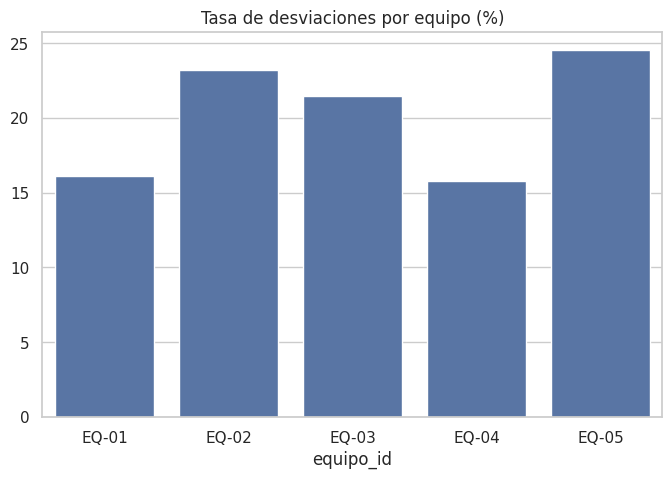

In [12]:
# Desviaciones por equipo
plt.figure(figsize=(8,5))
sns.barplot(x=desv_por_equipo.index, y=desv_por_equipo.values)
plt.title("Tasa de desviaciones por equipo (%)")
plt.show()

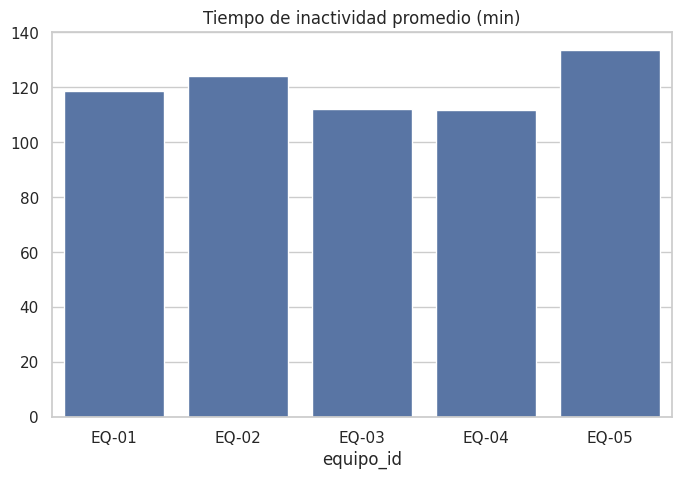

In [13]:
# Downtime promedio
plt.figure(figsize=(8,5))
sns.barplot(x=downtime_prom.index, y=downtime_prom.values)
plt.title("Tiempo de inactividad promedio (min)")
plt.show()

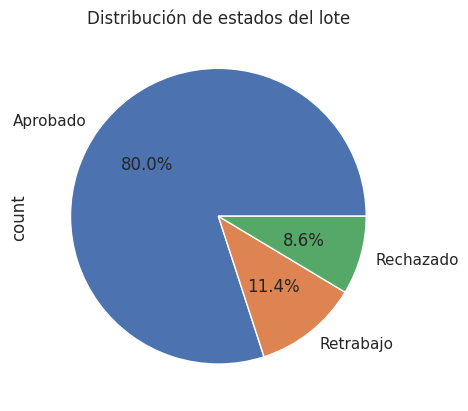

In [14]:
# Estado de lotes
pharma["estado_lote"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Distribución de estados del lote")
plt.show()

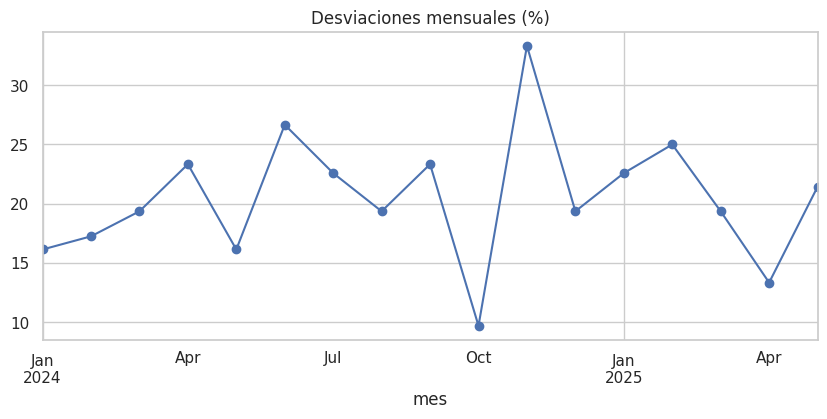

In [15]:
# Tendencia mensual
pharma["mes"] = pharma["fecha"].dt.to_period("M")
desv_mensual = pharma.groupby("mes")["desviacion"].mean()*100

desv_mensual.plot(figsize=(10,4), marker="o")
plt.title("Desviaciones mensuales (%)")
plt.show()

### Tabla de equipos críticos

In [16]:
criticos = pd.DataFrame({
    "desviaciones_%": desv_por_equipo,
    "downtime_promedio": downtime_prom
}).sort_values(["desviaciones_%","downtime_promedio"], ascending=False)

criticos

,desviaciones_%,downtime_promedio
equipo_id,,
EQ-05,24.528302,133.471698
EQ-02,23.232323,123.949495
EQ-03,21.495327,112.214953
EQ-01,16.129032,118.774194
EQ-04,15.789474,111.894737


from matplotlib import pyplot as plt
_df_0['desviaciones_%'].plot(kind='hist', bins=20, title='desviaciones_%')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['downtime_promedio'].plot(kind='hist', bins=20, title='downtime_promedio')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('equipo_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='desviaciones_%', y='downtime_promedio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['desviaciones_%'].plot(kind='line', figsize=(8, 4), title='desviaciones_%')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['downtime_promedio'].plot(kind='line', figsize=(8, 4), title='downtime_promedio')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['equipo_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='desviaciones_%', y='equipo_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['equipo_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='downtime_promedio', y='equipo_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)